## Analysis on ACS Data

In [ ]:
# import the necessary libraries, install via pip if necessary
import requests
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Census API key
api_key = '2f6114afda1992ebc55e717af57c4a2e15227686'

In [76]:
# Function to fetch data from the Census API
def fetch_census_data(variables):
    base_url = 'https://api.census.gov/data/2021/acs/acs5'
    variable_string = ','.join(variables)
    url = f'{base_url}?get=NAME,{variable_string}&for=place:*&key={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return pd.DataFrame(data[1:], columns=data[0])
    else:
        print(f'Error fetching data for {variables}:', response.status_code)
        return pd.DataFrame()
    
# Variables to fetch
variables = ['B25077_001E', 'B25103_001E']

# Fetch data
df = fetch_census_data(variables)

# Visualize the raw fetched data
df.head()

,NAME,B25077_001E,B25103_001E,state,place
0,"Abanda CDP, Alabama",60600,-666666666,01,00100
1,"Abbeville city, Alabama",88000,427,01,00124
2,"Adamsville city, Alabama",107100,595,01,00460
3,"Addison town, Alabama",106500,356,01,00484
4,"Akron town, Alabama",39400,199,01,00676


In [77]:
# Drop unnecessary columns by name (if any)
columns_to_drop = ['state', 'county', 'tract']  # Example columns to drop
df = df.drop(columns=columns_to_drop, errors='ignore')

# Rename columns for clarity
df = df.rename(columns={
    'B25077_001E': 'Median_Housing_Value',
    'B25103_001E': 'Property_Taxes_Paid'
})

# Convert relevant columns to numeric
df[['Median_Housing_Value', 'Property_Taxes_Paid']] = df[['Median_Housing_Value', 'Property_Taxes_Paid']].apply(pd.to_numeric, errors='coerce')

# Handle missing values
df.dropna(subset=['Median_Housing_Value', 'Property_Taxes_Paid'], inplace=True)

# Remove invalid data
df = df[(df['Property_Taxes_Paid'] >= 0) & (df['Median_Housing_Value'] > 0)]

# Remove useless column
column_to_drop = ['place']
df = df.drop(columns=column_to_drop, errors='ignore')

# Calculate effective tax rate
df['Effective_Tax_Rate'] = (df['Property_Taxes_Paid'] / df['Median_Housing_Value']) * 100

# round the effective tax rate to 2 decimal places
df['Effective_Tax_Rate'] = df['Effective_Tax_Rate'].round(2)

# Visualize the cleaned fetched data
df.head()

,NAME,Median_Housing_Value,Property_Taxes_Paid,Effective_Tax_Rate
1,"Abbeville city, Alabama",88000,427,0.49
2,"Adamsville city, Alabama",107100,595,0.56
3,"Addison town, Alabama",106500,356,0.33
4,"Akron town, Alabama",39400,199,0.51
5,"Alabaster city, Alabama",189600,930,0.49


In [78]:
investigated_cities = [
    "Albuquerque city, New Mexico", "Anchorage municipality, Alaska", "Arlington city, Texas", "Atlanta city, Georgia",
    "Aurora city, Illinois", "Austin city, Texas", "Bakersfield city, California", "Baltimore city, Maryland",
    "Billings city, Montana", "Birmingham city, Alabama", "Boise City city, Idaho", "Boston city, Massachusetts",
    "Bridgeport city, Connecticut", "Buffalo city, New York", "Charleston city, South Carolina",
    "Charlotte city, North Carolina", "Cheyenne city, Wyoming", "Chicago city, Illinois",
    "Colorado Springs city, Colorado", "Columbus city, Ohio", "Dallas city, Texas", "Denver city, Colorado",
    "Des Moines city, Iowa", "Detroit city, Michigan", "El Paso city, Texas", "Fargo city, North Dakota",
    "Fort Worth city, Texas", "Fresno city, California", "Houston city, Texas", "Indianapolis city (balance), Indiana",
    "Jacksonville city, Florida", "Kansas City city, Missouri", "Las Vegas city, Nevada", "Little Rock city, Arkansas",
    "Long Beach city, California", "Los Angeles city, California", "Louisville/Jefferson County metro government (balance), Kentucky", "Manchester city, New Hampshire",
    "Memphis city, Tennessee", "Mesa city, Arizona", "Miami city, Florida", "Milwaukee city, Wisconsin",
    "Minneapolis city, Minnesota", "Nashville-Davidson metropolitan government (balance), Tennessee", "New Orleans city, Louisiana", "New York city, New York",
    "Newark city, New Jersey", "Oakland city, California", "Oklahoma City city, Oklahoma", "Omaha city, Nebraska",
    "Philadelphia city, Pennsylvania", "Phoenix city, Arizona", "Portland city, Maine", "Portland city, Oregon",
    "Providence city, Rhode Island", "Raleigh city, North Carolina", "Sacramento city, California", "Salt Lake City city, Utah",
    "San Antonio city, Texas", "San Diego city, California", "San Francisco city, California", "San Jose city, California",
    "Seattle city, Washington", "Sioux Falls city, South Dakota", "Tucson city, Arizona", "Tulsa city, Oklahoma",
    "Urban Honolulu CDP, Hawaii", "Virginia Beach city, Virginia", "Washington city, District of Columbia",
    "Wichita city, Kansas", "Wilmington city, Delaware"
]

# filter investigated_cities only
df_filtered = df[df['NAME'].isin(investigated_cities)]

# sort the NAME column using alphabetical orderm, rename the dataframe to df_acs
df_acs = df_filtered.sort_values(by='NAME')

# set the index to NAME
df_acs.set_index('NAME', inplace=True)

df_acs.head()

,Median_Housing_Value,Property_Taxes_Paid,Effective_Tax_Rate
NAME,,,
"Albuquerque city, New Mexico",214600,2327,1.08
"Anchorage municipality, Alaska",327500,4407,1.35
"Arlington city, Texas",210800,3935,1.87
"Atlanta city, Georgia",346600,3410,0.98
"Aurora city, Illinois",208500,5442,2.61


In [79]:
# Change labels to match with the paper
df_acs['City'] = [
        "Albuquerque, NM", "Anchorage, AK", "Arlington, TX", "Atlanta, GA",
        "Aurora, IL", "Austin, TX", "Bakersfield, CA", "Baltimore, MD", "Billings, MT", 
        "Birmingham, AL", "Boise City, ID", "Boston, MA", "Bridgeport, CT", "Buffalo, NY",
        "Charleston, SC", "Charlotte, NC", "Cheyenne, WY", 
        "Chicago, IL", "Colorado Springs, CO", "Columbus, OH", "Dallas, TX", "Denver, CO", 
        "Des Moines, IA", "Detroit, MI", "El Paso, TX", "Fargo, ND", "Fort Worth, TX", 
        "Fresno, CA", "Houston, TX", "Indianapolis city, IN", "Jacksonville, FL", "Kansas City, MO",
        "Las Vegas, NV", "Little Rock, AR", "Long Beach, CA", "Los Angeles, CA", "Louisville, KY", 
        "Manchester, NH", "Memphis, TN", "Mesa, AZ", "Miami, FL", "Milwaukee, WI", 
        "Minneapolis, MN", "Nashville, TN", "New Orleans, LA", "New York, NY", "Newark, NJ", 
        "Oakland, CA", "Oklahoma City, OK", "Omaha, NE", "Philadelphia, PA", "Phoenix, AZ", 
        "Portland, ME", "Portland, OR", "Providence, RI", "Raleigh, NC", "Sacramento, CA", 
        "Salt Lake City, UT", "San Antonio, TX", "San Diego, CA", "San Francisco, CA", 
        "San Jose, CA", "Seattle, WA", "Sioux Falls, SD", "Tucson, AZ", "Tulsa, OK", 
        "Urban Honolulu, HI", "Virginia Beach, VA", "Washington, DC", "Wichita, KS", 
        "Wilmington, DE"
    ]

df_acs.set_index('City', inplace=True)

df_acs

,Median_Housing_Value,Property_Taxes_Paid,Effective_Tax_Rate
City,,,
"Albuquerque, NM",214600,2327,1.08
"Anchorage, AK",327500,4407,1.35
"Arlington, TX",210800,3935,1.87
"Atlanta, GA",346600,3410,0.98
"Aurora, IL",208500,5442,2.61
...,...,...,...
"Urban Honolulu, HI",726000,2180,0.30
"Virginia Beach, VA",295900,2639,0.89
"Washington, DC",635900,3641,0.57


## Extract the data from the Paper and merge with ACS data

In [80]:
# Data extracted from the table in the paper for future analysis
data = {
    'City': [
        "Albuquerque, NM", "Anchorage, AK", "Arlington, TX", "Atlanta, GA",
        "Aurora, IL", "Austin, TX", "Bakersfield, CA", "Baltimore, MD", "Billings, MT", 
        "Birmingham, AL", "Boise City, ID", "Boston, MA", "Bridgeport, CT", "Buffalo, NY", 
        "Burlington, VT", "Charleston, SC", "Charleston, WV", "Charlotte, NC", "Cheyenne, WY", 
        "Chicago, IL", "Colorado Springs, CO", "Columbus, OH", "Dallas, TX", "Denver, CO", 
        "Des Moines, IA", "Detroit, MI", "El Paso, TX", "Fargo, ND", "Fort Worth, TX", 
        "Fresno, CA", "Houston, TX", "Indianapolis city, IN", "Jacksonville, FL", "Kansas City, MO",
        "Las Vegas, NV", "Little Rock, AR", "Long Beach, CA", "Los Angeles, CA", "Louisville, KY", 
        "Manchester, NH", "Memphis, TN", "Mesa, AZ", "Miami, FL", "Milwaukee, WI", 
        "Minneapolis, MN", "Nashville, TN", "New Orleans, LA", "New York, NY", "Newark, NJ", 
        "Oakland, CA", "Oklahoma City, OK", "Omaha, NE", "Philadelphia, PA", "Phoenix, AZ", 
        "Portland, ME", "Portland, OR", "Providence, RI", "Raleigh, NC", "Sacramento, CA", 
        "Salt Lake City, UT", "San Antonio, TX", "San Diego, CA", "San Francisco, CA", 
        "San Jose, CA", "Seattle, WA", "Sioux Falls, SD", "Tucson, AZ", "Tulsa, OK", 
        "Urban Honolulu, HI", "Virginia Beach, VA", "Washington, DC", "Wichita, KS", 
        "Wilmington, DE"
    ],
    'De Jure Tax Rate (median)': [
        1.28, 1.32, 2.29, 0.90, 3.11, 1.82, 1.17, 2.22, 0.88, 0.67, 0.64, 0.51, 2.26, 1.43, 
        1.62, 0.49, 0.59, 0.85, 0.65, 1.57, 0.47, 1.66, 2.12, 0.53, 2.26, 3.27, 2.60, 1.19, 
        2.32, 1.23, 1.69, 1.15, 1.27, 1.32, 1.13, 0.31, 1.12, 0.95, 1.18, 0.79, 1.16, 0.75, 
        1.33, 0.92, 1.30, 1.51, 1.69, 1.11, 0.84, 0.39, 1.64, 1.43, 2.48, 1.98, 1.24, 1.22, 
        0.82, 0.65, 1.00, 0.97, 1.20, 0.90, 3.23, 1.70, 1.36, 0.96, 1.23, 1.07, 1.99, 1.63, 
        0.98, 0.78, 1.20
    ],
    'De Facto Tax Rate (median)': [
        0.95, 1.39, 1.78, 1.12, 2.34, 1.43, 1.06, 2.24, 0.86, 0.76, 0.66, 0.69, 2.29, 0.37, 
        1.85, 0.46, 0.81, 0.67, 0.57, 1.54, 0.34, 1.33, 1.79, 0.46, 1.88, 1.67, 2.35, 1.30, 
        1.69, 0.82, 1.38, 0.90, 0.97, 1.09, 1.13, 0.82, 1.12, 0.95, 1.18, 0.90, 1.16, 0.74, 
        1.10, 0.82, 0.64, 0.50, 2.54, 1.95, 1.32, 0.77, 1.18, 0.90, 1.27, 0.80, 0.81, 0.71, 
        1.52, 1.20, 1.07, 0.70, 1.37, 1.08, 0.30, 0.31, 0.89, 0.81, 0.74, 0.65, 1.20, 0.95, 
        1.37, 1.17, 0.98
    ]
}

# Create the DataFrame
df_paper_data = pd.DataFrame(data)

# drop unfound cities in ACS ("Burlington, VT" and "Charleston city, West Virginia")
df_paper_data = df_paper_data[~df_paper_data['City'].isin(['Burlington, VT', 'Charleston, WV'])]

df_paper_data.set_index('City', inplace=True)

df_paper_data


,De Jure Tax Rate (median),De Facto Tax Rate (median)
City,,
"Albuquerque, NM",1.28,0.95
"Anchorage, AK",1.32,1.39
"Arlington, TX",2.29,1.78
"Atlanta, GA",0.90,1.12
"Aurora, IL",3.11,2.34
...,...,...
"Urban Honolulu, HI",1.99,1.20
"Virginia Beach, VA",1.63,0.95
"Washington, DC",0.98,1.37


In [74]:
# Merge the two dataframes side by side (acs data on the left, paper data on the right)
df_summary = df_acs.merge(df_paper_data, left_index=True, right_index=True)

df_summary

,Median_Housing_Value,Property_Taxes_Paid,Effective_Tax_Rate,De Jure Tax Rate (median),De Facto Tax Rate (median)
City,,,,,
"Albuquerque, NM",214600,2327,1.08,1.28,0.95
"Anchorage, AK",327500,4407,1.35,1.32,1.39
"Arlington, TX",210800,3935,1.87,2.29,1.78
"Atlanta, GA",346600,3410,0.98,0.90,1.12
"Aurora, IL",208500,5442,2.61,3.11,2.34
...,...,...,...,...,...
"Urban Honolulu, HI",726000,2180,0.30,1.99,1.20
"Virginia Beach, VA",295900,2639,0.89,1.63,0.95
"Washington, DC",635900,3641,0.57,0.98,1.37


## Results and Findings

### Variables Definition

This table contains various metrics related to property values and tax rates for different cities. Below are the definitions of each variable:

- **Median_Housing_Value**:
  - **Definition**: This variable represents the median value of owner-occupied housing units in dollars. It is the middle value in the list of all housing values for owner-occupied units, meaning half the homes are valued above this number and half below.
  - **Source**: American Community Survey (ACS) 5-Year Estimates, Table B25077_001E.

- **Property_Taxes_Paid**:
  - **Definition**: This variable represents the median amount of real estate taxes paid annually by homeowners in dollars. It includes all state, county, and local property taxes paid.
  - **Source**: American Community Survey (ACS) 5-Year Estimates, Table B25103_001E.

- **Effective_Tax_Rate**:
  - **Definition**: This calculated variable represents the effective property tax rate, determined by dividing the annual property taxes paid by the median housing value and then multiplying by 100 to express it as a percentage.
  - **Calculation**: \((\text{Property_Taxes_Paid} / \text{Median_Housing_Value}) \times 100\)

- **De Jure Tax Rate (median)**:
  - **Definition**: This variable represents the nominal or statutory property tax rate reported by local governments, typically expressed as a percentage of the assessed property value. It is the tax rate officially enacted by law.
  - **Source**: Paper

- **De Facto Tax Rate (median)**:
  - **Definition**: This variable represents the actual or effective property tax rate experienced by homeowners, based on the taxes they actually pay relative to the current market value of their homes. It accounts for discrepancies due to assessment lags and exemptions.
  - **Source**: Paper


### Plot the Relationship among Calculated Tax rate (based on ACS data) and De Jure & De Facto (From the paper)

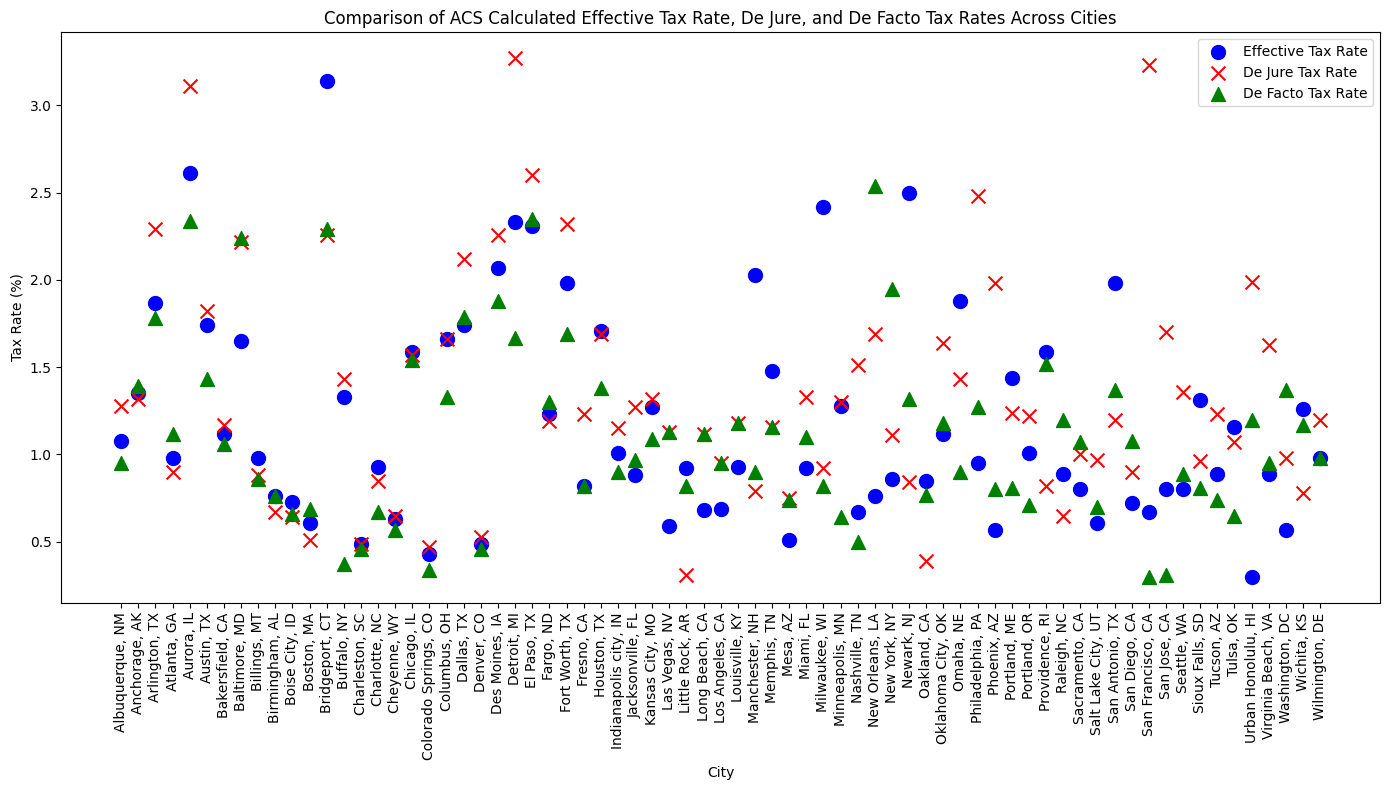

In [81]:
# Plotting
plt.figure(figsize=(14, 8))

# Scatter plot for Effective Tax Rate
plt.scatter(df_summary.index, df_summary['Effective_Tax_Rate'], color='blue', label='Effective Tax Rate', s=100)

# Scatter plot for De Jure Tax Rate
plt.scatter(df_summary.index, df_summary['De Jure Tax Rate (median)'], color='red', label='De Jure Tax Rate', s=100, marker='x')

# Scatter plot for De Facto Tax Rate
plt.scatter(df_summary.index, df_summary['De Facto Tax Rate (median)'], color='green', label='De Facto Tax Rate', s=100, marker='^')

# Adding titles and labels
plt.title('Comparison of ACS Calculated Effective Tax Rate, De Jure, and De Facto Tax Rates Across Cities')
plt.xlabel('City')
plt.ylabel('Tax Rate (%)')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

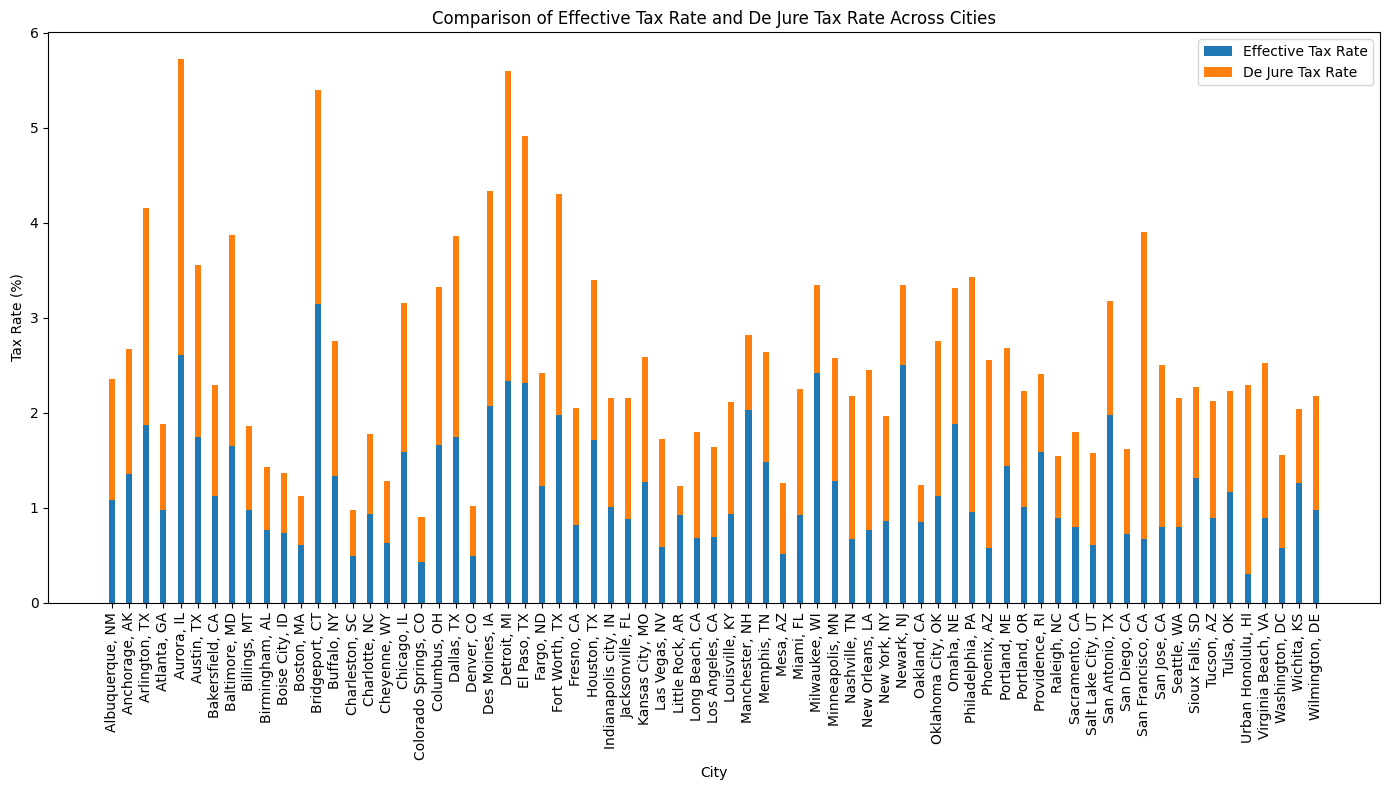

In [70]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Define the width of the bars
bar_width = 0.35

# Define the positions of the bars
index = df_summary.index

# Create bar plots
bar1 = ax.bar(index, df_summary['Effective_Tax_Rate'], bar_width, label='Effective Tax Rate')
bar2 = ax.bar(index, df_summary['De Jure Tax Rate (median)'], bar_width, bottom=df_summary['Effective_Tax_Rate'], label='De Jure Tax Rate')

# Adding titles and labels
ax.set_title('Comparison of Effective Tax Rate and De Jure Tax Rate Across Cities')
ax.set_xlabel('City')
ax.set_ylabel('Tax Rate (%)')
ax.set_xticks(index)
ax.set_xticklabels(index, rotation=90)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

### Statistical Analysis

In [71]:
## Variation in Tax rates
variation = df_summary['Effective_Tax_Rate'].describe()
print(variation)

count    71.000000
mean      1.194366
std       0.605276
min       0.300000
25%       0.760000
50%       0.980000
75%       1.590000
max       3.140000
Name: Effective_Tax_Rate, dtype: float64


In [72]:
# Correlation Analysis
import scipy.stats as stats

# Calculate Pearson correlation coefficient and p-value
correlation, p_value = stats.pearsonr(df_summary['Effective_Tax_Rate'], df_summary['De Jure Tax Rate (median)'])

# Display the results
print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.4747894431234499
P-value: 2.8717506728255876e-05


In [73]:
# Regressivity of Tax Rates

df_summary['Value_Quintile'] = pd.qcut(df_summary['Median_Housing_Value'], 5)
quintile_effective_rates = df_summary.groupby('Value_Quintile')['Effective_Tax_Rate'].mean()
print(quintile_effective_rates)

Value_Quintile
(57699.999, 174400.0]    1.520000
(174400.0, 218600.0]     1.581429
(218600.0, 277700.0]     1.214286
(277700.0, 381400.0]     0.929286
(381400.0, 1194500.0]    0.703571
Name: Effective_Tax_Rate, dtype: float64


/var/folders/dj/fvlq7lhs5l3_gvmgbf3_wcx00000gn/T/ipykernel_10967/711818723.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_effective_rates = df_summary.groupby('Value_Quintile')['Effective_Tax_Rate'].mean()
